In [1]:
import os
os.environ["PATH"] = "/s/ls4/users/mikhakuv/enviroments/jax_clean/bin"

In [2]:
import jax
jax.devices()

[cuda(id=0)]

In [3]:
import time
import numpy as np
from jax import random
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import NonlinearSchrodingerEquationHighOrder
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, SIREN, AdaptiveSIREN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_0=-10
x_1=10
t_0=0
t_1=1
x_parts=200
t_parts=1000

subdomain_xs=[np.linspace(x_0,x_1, 2), np.linspace(t_0,t_1, 10)] #задаёт сетку разбиения на области
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_0,t_0]), #крайние точки рассматриваемой прямоугольной области
        xmax=np.array([x_1,t_1])
        ),
    problem=NonlinearSchrodingerEquationHighOrder, #решаемое уравнение
    problem_init_kwargs = dict(), #параметры уравнения, если есть
    decomposition=RectangularDecompositionND, #исходную область разбиваем на прямоугольные области
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 1.5), #с наезжанием границ 2.0
        unnorm=(0.0, 3), #денормализация
    ),
    #network=FCN, #используем полносвязные нейросети с функцией активации tanh
    network=SIREN, #используем полносвязные нейросети с функцией активации sin
    #network=AdaptiveSIREN, #используем полносвязные адаптивные нейросети с функцией активации sin (там функция активации имеет вид c*sin(o*x), где с и o - дополнительные параметры)
    
    network_init_kwargs = dict(layer_sizes = (2, 20, 20, 20, 2),), #с такой топологией
    scheduler = LineSchedulerRectangularND, #планировщик, шагающий с t=0 вдоль оси 0(которая x)
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    ns=((200,1000),), #200*100 точек, в которых сеть учится удовлетворять уравнению
    n_test=(400,2000), #2000*500 точек для определения ошибки по сравнению с аналитическим решением
    n_steps=2000000, #число шагов при обучении
    clear_output=True,
)

run = FBPINNTrainer(c) #передаём заданные параметры в оптимизатор

[INFO] 2024-09-08 10:30:04 - <fbpinns.constants.Constants object at 0x2aec87f60250>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-10,   0]), 'xmax': array([10,  1])}
problem: <class 'fbpinns.problems.NonlinearSchrodingerEquationHighOrder'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-10.,  10.]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([30., 30.]), array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667])], 'unnorm': (0.0, 3)}
network: <class 'fbpinns.networks.SIREN'>
network_init_kwargs: {'layer_sizes': (2, 20, 20, 20, 2)}
n_steps: 2000000
scheduler: <class 'fbpinns.schedulers.LineSchedulerRectangularND'>
scheduler_kwargs: {'point':

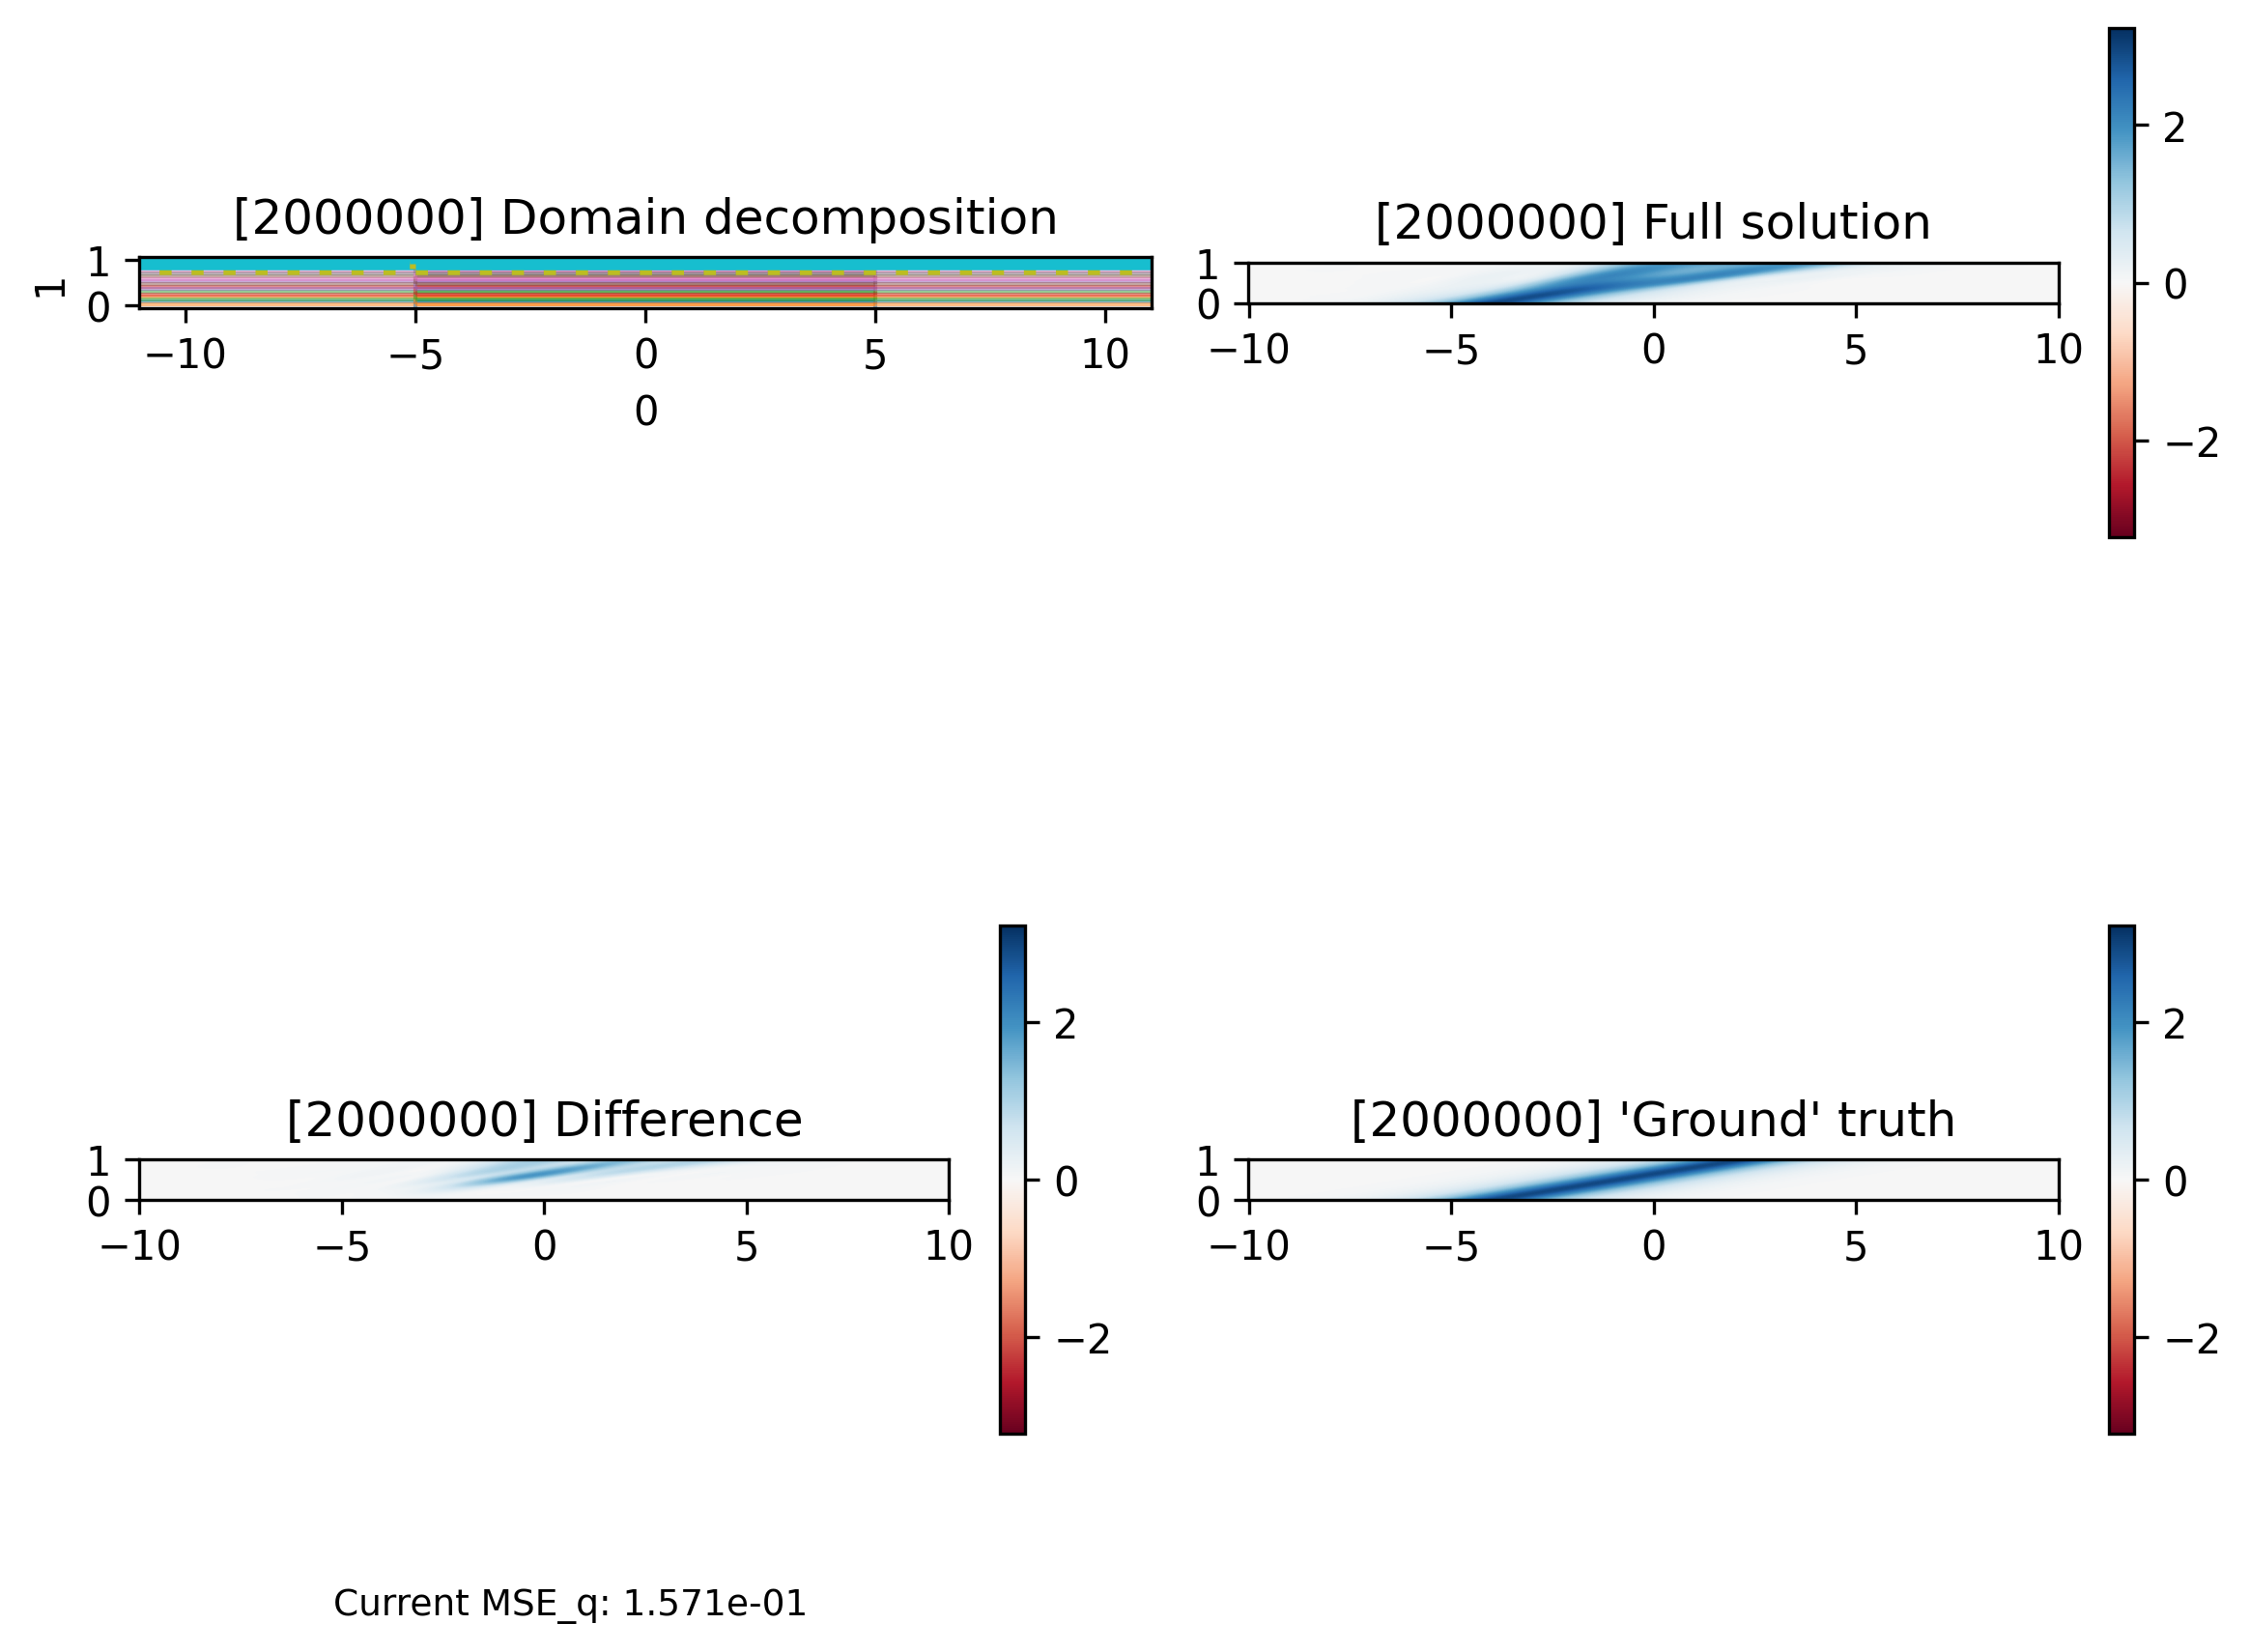

[INFO] 2024-09-09 03:20:44 - [i: 2000000/2000000] Training complete
CPU times: user 2h 6min 32s, sys: 18min 43s, total: 2h 25min 15s
Wall time: 16h 50min 39s


In [4]:
%%time
all_params = run.train() #запускаем обучение

In [10]:
from fbpinns.analysis import load_model, FBPINN_solution
from fbpinns.problems import q
import matplotlib.pyplot as plt
import jax.numpy as jnp

#создаём точки
x = jnp.linspace(x_0, x_1, x_parts)
t = jnp.linspace(t_0, t_1, t_parts)
X, T = jnp.meshgrid(x, t)
XT_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
x_star = X.flatten()[:,None]
t_star = T.flatten()[:,None]

#вычисляем верные значения
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]
Exact_q_abs = (Exact_u**2 + Exact_v**2)**0.5
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]
q_abs_star = Exact_q_abs.flatten()[:,None]

#вычисляем предсказанные значения
c, model = load_model(run="test", rootdir="results/")
i, all_params, all_opt_states, active, u_test_losses = model
UV_pred = FBPINN_solution(c, all_params, active, XT_star)
u_pred = UV_pred[:,0:1]
v_pred = UV_pred[:,1:2]
q_abs_pred = (u_pred**2 + v_pred**2)**0.5

[INFO] 2024-09-09 08:23:16 - Loading model from:
results/models/test/model_02000000.jax
[INFO] 2024-09-09 08:23:17 - x_batch
[INFO] 2024-09-09 08:23:17 - (200000, 2), float32, ndarray
[INFO] 2024-09-09 08:23:17 - x_take
[INFO] 2024-09-09 08:23:17 - (451200, 2), float32, ndarray


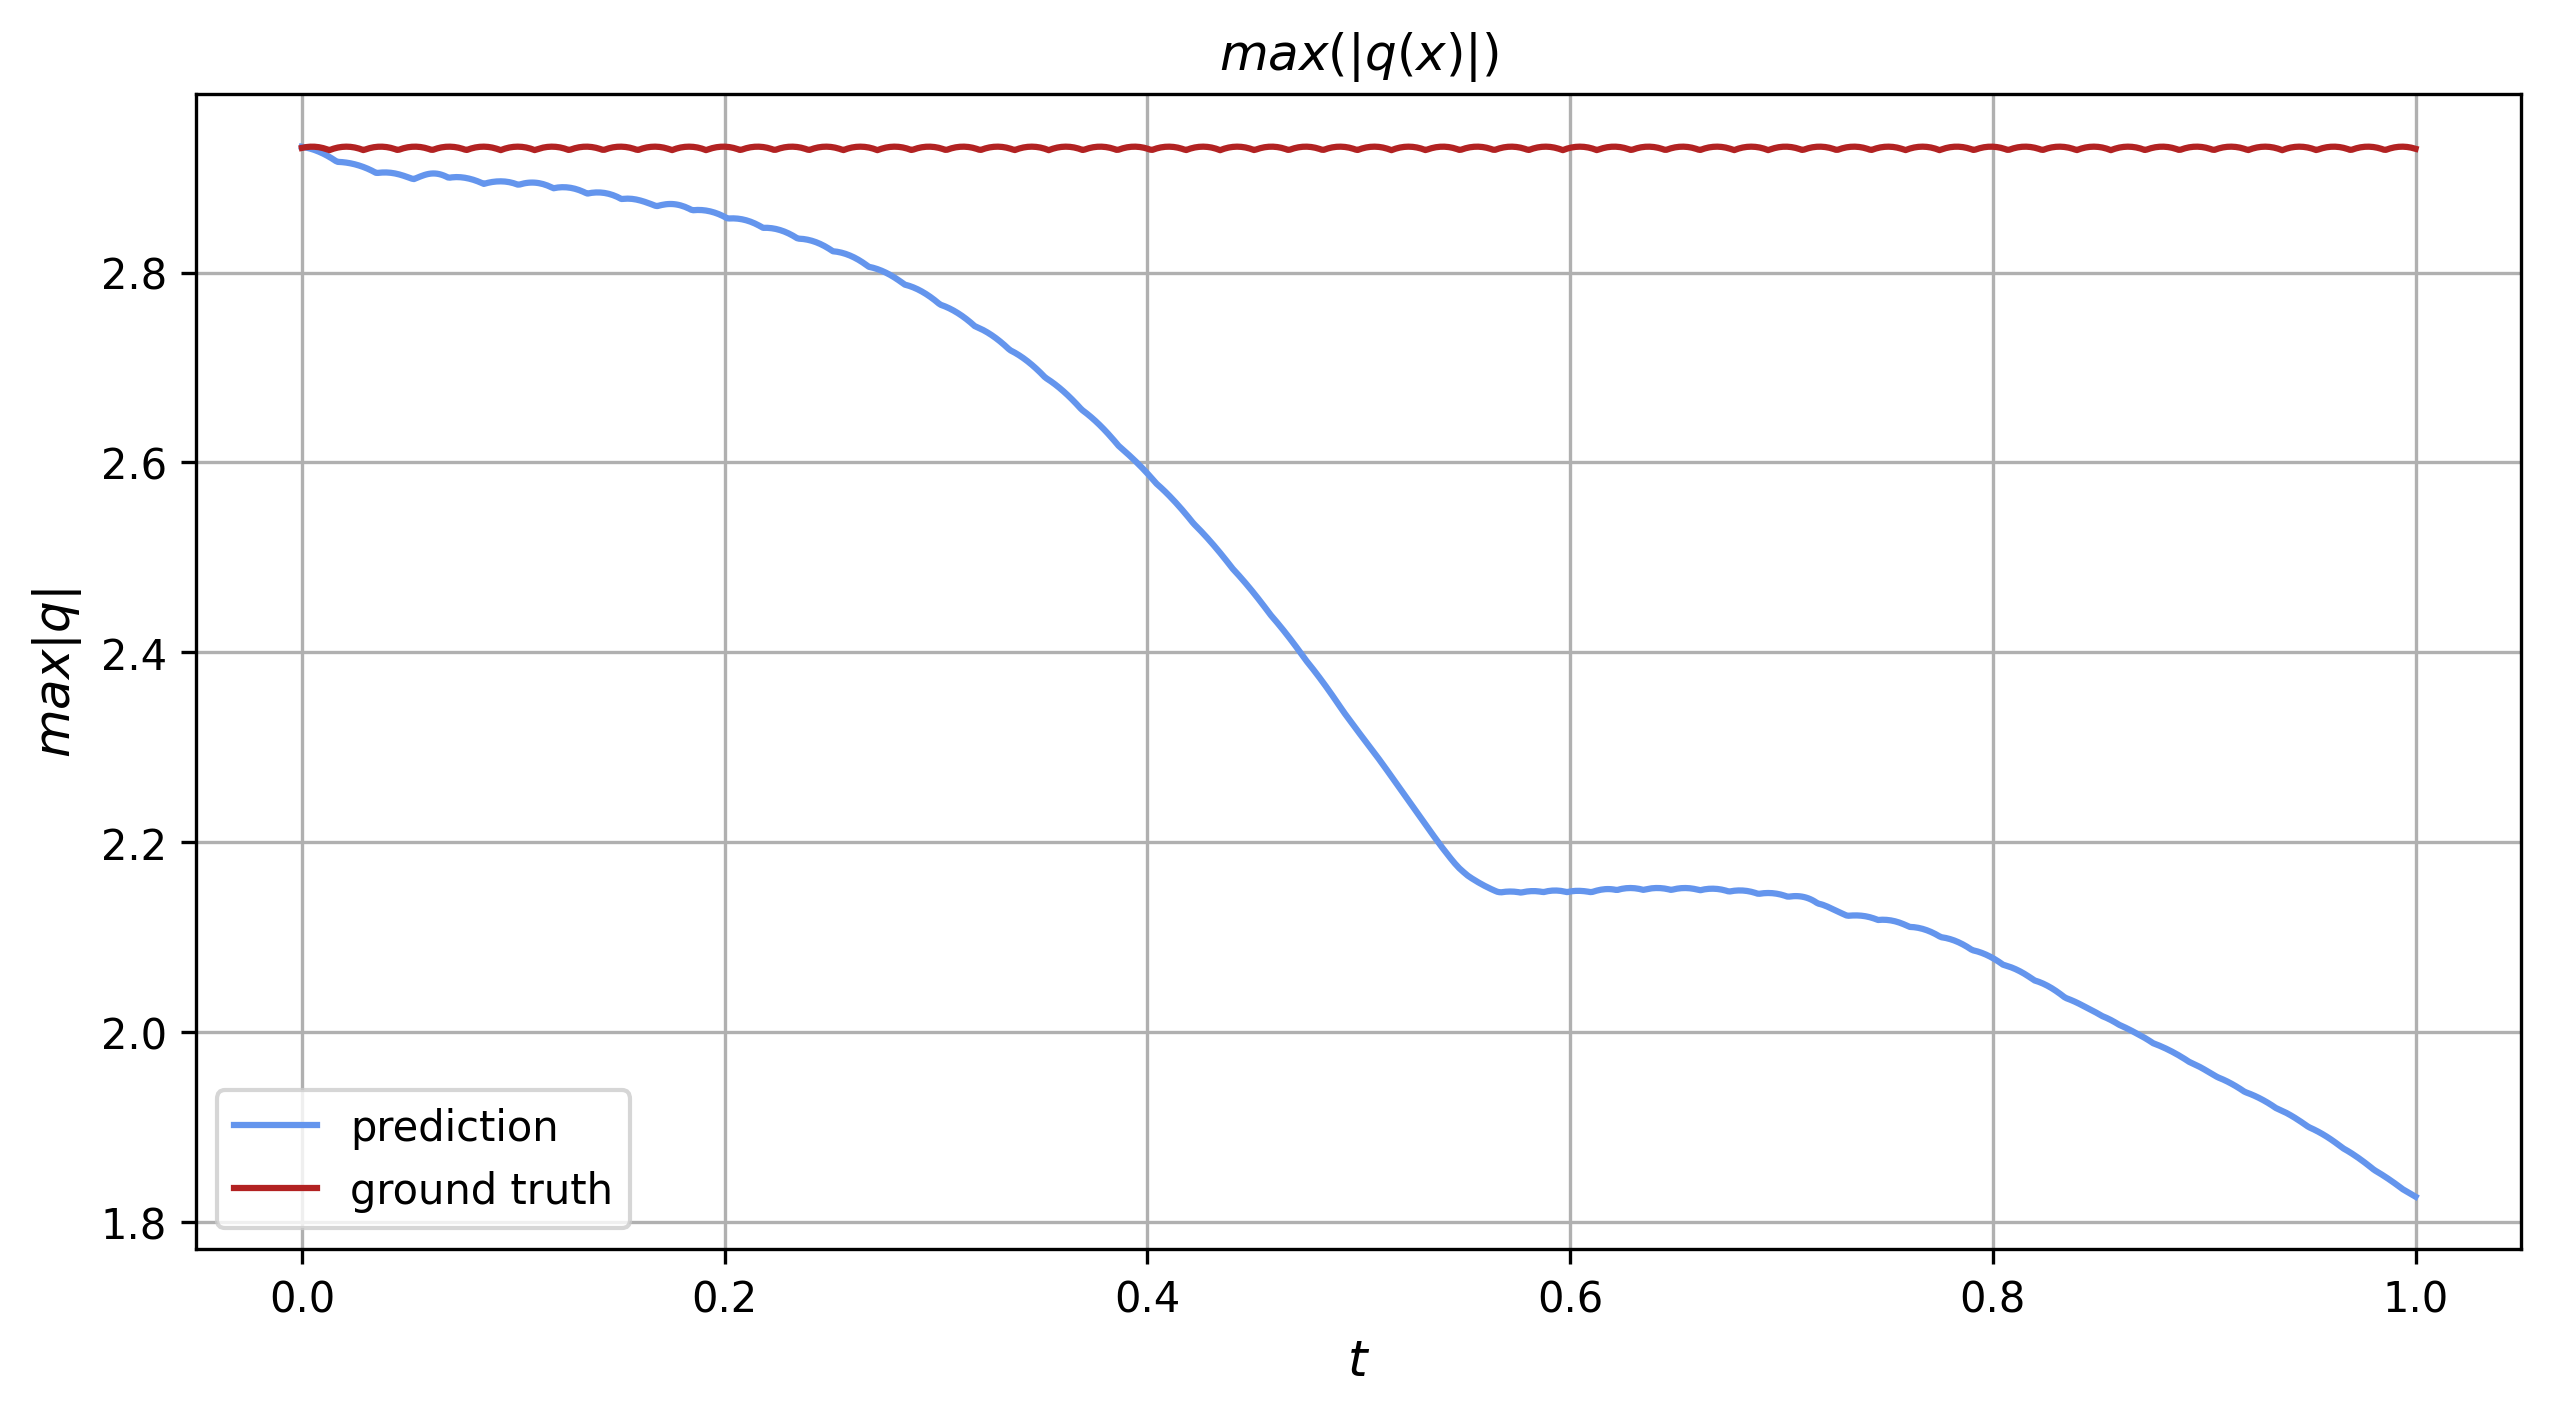

In [11]:
plt.figure(figsize=(10,5))
plt.plot(T[::1,0], jnp.max(q_abs_pred.reshape((t_parts, x_parts)), axis=1)[::1], color = "cornflowerblue", label='prediction')
plt.plot(T[:,0], jnp.max(q_abs_star.reshape((t_parts, x_parts)), axis=1), color = "firebrick", label='ground truth')
plt.title(r'$max(|q(x)|)$'%t)
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$max |q|$', fontsize=12)
middle = jnp.max(q_abs_star.reshape((t_parts, x_parts)), axis=1)[0]
#plt.ylim((middle-0.02, middle+0.02))
plt.grid(True)
plt.legend()
plt.savefig("6th_order_amplitude.png")
plt.show()

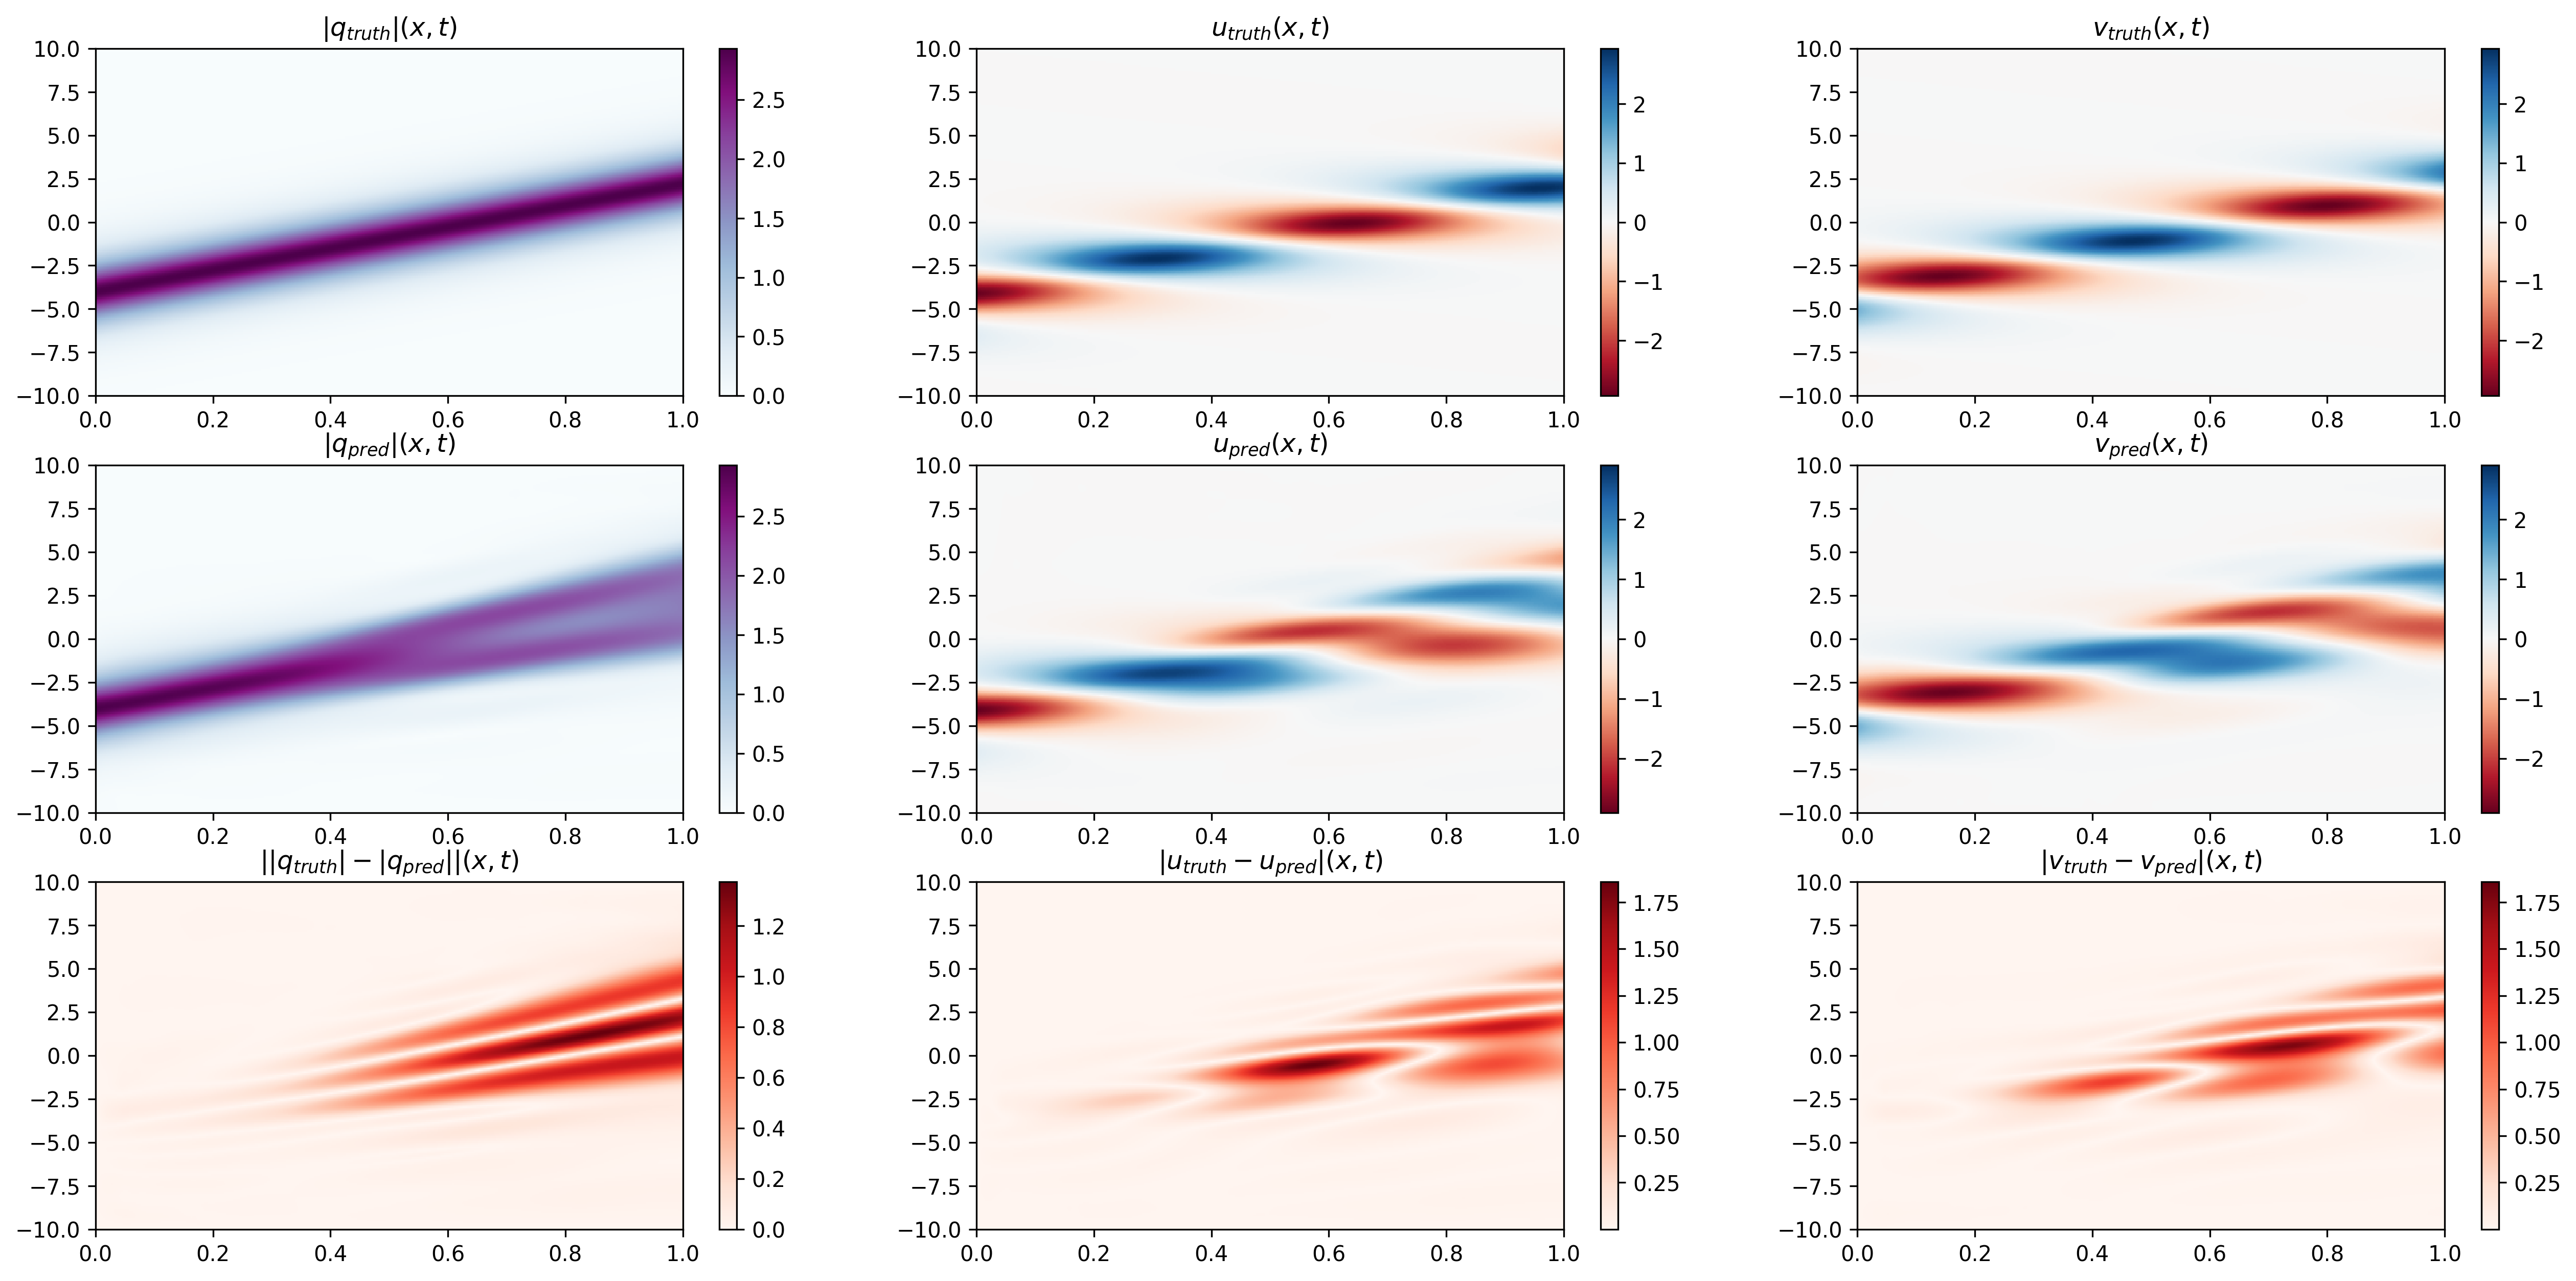

In [12]:
#строим графики
fig, axs = plt.subplots(3, 3, figsize=(21,10), dpi=300)

q_abs_min, q_abs_max = 0, np.abs(q_abs_star).max()
c = axs[0,0].pcolormesh(T, X, q_abs_star.reshape((t_parts, x_parts)), cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
axs[0,0].set_title('$|q_{truth}|(x,t)$')
axs[0,0].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[0,0])

u_min, u_max = -np.abs(u_star).max(), np.abs(u_star).max()
c = axs[0,1].pcolormesh(T, X, u_star.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
axs[0,1].set_title('$u_{truth}(x,t)$')
axs[0,1].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[0,1])

c = axs[0,2].pcolormesh(T, X, v_star.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
axs[0,2].set_title('$v_{truth}(x,t)$')
axs[0,2].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[0,2])


q_abs_min, q_abs_max = 0, np.abs(q_abs_pred).max()
c = axs[1,0].pcolormesh(T, X, q_abs_pred.reshape((t_parts, x_parts)), cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
axs[1,0].set_title('$|q_{pred}|(x,t)$')
axs[1,0].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[1,0])

u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = axs[1,1].pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
axs[1,1].set_title('$u_{pred}(x,t)$')
axs[1,1].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[1,1])

c = axs[1,2].pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
axs[1,2].set_title('$v_{pred}(x,t)$')
axs[1,2].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[1,2])


u_diff = np.abs(u_star-u_pred)
v_diff = np.abs(v_star-v_pred)
q_abs_diff = np.abs(q_abs_star-q_abs_pred)

q_abs_min, q_abs_max = 0, np.abs(q_abs_diff).max()
c = axs[2,0].pcolormesh(T, X, q_abs_diff.reshape((t_parts, x_parts)), cmap='Reds', vmin=q_abs_min, vmax=q_abs_max)
axs[2,0].set_title('$||q_{truth}|-|q_{pred}||(x,t)$')
axs[2,0].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[2,0])

u_min, u_max = u_diff.min(), u_diff.max()
c = axs[2,1].pcolormesh(T, X, u_diff.reshape((t_parts, x_parts)), cmap='Reds', vmin=u_min, vmax=u_max)
axs[2,1].set_title('$|u_{truth}-u_{pred}|(x,t)$')
axs[2,1].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[2,1])

c = axs[2,2].pcolormesh(T, X, v_diff.reshape((t_parts, x_parts)), cmap='Reds', vmin=u_min, vmax=u_max)
axs[2,2].set_title('$|v_{truth}-v_{pred}|(x,t)$')
axs[2,2].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[2,2])

plt.savefig("6th_order_charts.png")
plt.show()

In [13]:
mse_q = np.mean((q_abs_pred - q_abs_star)**2)
rel_h = np.linalg.norm(q_abs_pred - q_abs_star, 2)/np.linalg.norm(q_abs_star, 2)
print(f'MSE_q: {mse_q:.3e}, Rel_h: {rel_h:.3e}')

MSE_q: 7.674e-02, Rel_h: 2.995e-01


In [14]:
#сохраняем результаты в таблицу
import pandas as pd
data = pd.DataFrame({'x': x_star[:,0],
                     't': t_star[:,0],
                     'true_u': u_star[:,0],
                     'true_v': v_star[:,0],
                     'true_h': q_abs_star[:,0],
                     'pred_u': u_pred[:,0],
                     'pred_v': v_pred[:,0],
                     'pred_h': q_abs_pred[:,0]})
data.to_csv('6th_order_data.csv', index=False)
data.to_orc('6th_order_data.orc', index=False)